In [1]:
!nvidia-smi

Thu May 28 08:54:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   26C    P8    13W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   24C    P8     4W / 250W |    199MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [3]:
import glob
import cv2


def load_data(phase, cls, les = None, data = 'sm', data_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed', 
              extract_name = True, image_ch = 'rgb'):
    """
    phase = 'train', 'test'
    cls: [les]  
      'n': ['neg']
      'h': ['redspot', 'angio', 'active'], 
      'd': ['ero', 'ulc', 'str'],
      'p': ['amp', 'lym', 'tum']}
    """
    lesions = dict(neg = 'negative', 
                   redspot = 'red_spot', angio = 'angioectasia', active = 'active_bleeding', 
                   ero = 'erosion', ulcer = 'ulcer', str = 'stricture', 
                   amp = 'ampulla_of_vater', lym = 'lymphoid_follicles', tum = 'small_bowel_tumor')
    classes = dict(n = 'negative', h = 'hemorrhagic', d = 'depressed', p = 'protruded')

    path = os.path.join(data_dir, data, phase, classes[cls], lesions[les])
    pathlist = glob.glob(path + '/*.jpg')
    
    new_pathlist = []
    for p in pathlist:
        name = os.path.basename(p)
        name_seg1 = name.split('___')[0]
        if not ('f_' in name_seg1 or 'r1_' in name_seg1 or 'r2_' in name_seg1 or 'r3_' in name_seg1):
            new_pathlist.append(p)
    return load_image_from_path(new_pathlist, image_ch = image_ch, extract_name = extract_name)

def load_image_from_path(pathlist,image_ch = 'bgr', extract_name = False):
    data = []
    for i in pathlist:
        temp = cv2.imread(i)
        if image_ch == 'bgr':
            pass
        elif image_ch == 'rgb':
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        elif image_ch == 'hsv':
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
        data.append(temp)
    if extract_name != False:
        name = []
        for i in pathlist:
            name.append(os.path.basename(i))
        return np.asarray(data), np.asarray(name)
    else:
        return np.asarray(data) 

In [4]:
neg_nh_img, neg_nh_name = load_data('test', 'n', 'neg', data = 'sm_core/nh')
neg_nd_img, neg_nd_name = load_data('test', 'n', 'neg', data = 'sm_core/nd')
neg_img, neg_name = np.vstack([neg_nh_img, neg_nd_img]), np.hstack([neg_nh_name, neg_nd_name])
redspot_img, redspot_name = load_data('test', 'h', 'redspot', data = 'sm_core/nh')
angio_img, angio_name = load_data('test', 'h', 'angio', data = 'sm_core/nh')
active_img, active_name = load_data('test', 'h', 'active', data = 'sm_core/nh')
ero_img, ero_name = load_data('test', 'd', 'ero', data = 'sm_core/nd')
ulcer_img, ulcer_name = load_data('test', 'd', 'ulcer', data = 'sm_core/nd')
str_img, str_name = load_data('test', 'd', 'str', data = 'sm_core/nd')

In [5]:
neg_nh_label = one_hot(neg_nh_img, 0)
neg_nd_label = one_hot(neg_nd_img, 0)
neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("total negative:",neg_img.shape, neg_label.shape)
print("negative for nh:",neg_nh_img.shape, neg_nh_label.shape)
print("negative for nd:",neg_nd_img.shape, neg_nd_label.shape)
print('')
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

total negative: (299, 512, 512, 3) (299, 2)
negative for nh: (98, 512, 512, 3) (98, 2)
negative for nd: (201, 512, 512, 3) (201, 2)

red spot: (46, 512, 512, 3) (46, 2)
angioectasia: (3, 512, 512, 3) (3, 2)
active_bleeding: (50, 512, 512, 3) (50, 2)
erosion: (97, 512, 512, 3) (97, 2)
ulcer: (95, 512, 512, 3) (95, 2)
stricture: (10, 512, 512, 3) (10, 2)


# Model Inference

In [6]:
nh_list = sorted([i[:-5] for i in os.listdir('./model/CORE') if 'meta' in i and 'CORE_rgb_NH' in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model/CORE') if 'meta' in i and 'CORE_rgb_ND' in i])
b_list = sorted([i[:-5] for i in os.listdir('./model/CORE') if 'meta' in i and 'CORE_rgb_B' in i])

In [7]:
nh_list

['CORE_rgb_NH_2001041908_8770_val_acc_1.00_val_loss_0.000000',
 'CORE_rgb_NH_2001041909_8890_val_acc_1.00_val_loss_0.000000',
 'CORE_rgb_NH_2001041909_8960_val_acc_1.00_val_loss_0.000000',
 'CORE_rgb_NH_2001041913_9360_val_acc_1.00_val_loss_0.000000',
 'CORE_rgb_NH_2001041914_9540_val_acc_1.00_val_loss_0.000000']

In [8]:
nd_list

['CORE_rgb_ND_2001041923_8910_val_acc_1.00_val_loss_0.000802',
 'CORE_rgb_ND_2001041925_9170_val_acc_1.00_val_loss_0.000772',
 'CORE_rgb_ND_2001042207_10030_val_acc_1.00_val_loss_0.000457',
 'CORE_rgb_ND_2001042207_10040_val_acc_1.00_val_loss_0.000284',
 'CORE_rgb_ND_2001042229_12730_val_acc_1.00_val_loss_0.000018']

In [9]:
b_list

['CORE_rgb_B_2001041918_7510_val_acc_1.00_val_loss_0.004834',
 'CORE_rgb_B_2001041919_7670_val_acc_1.00_val_loss_0.001308',
 'CORE_rgb_B_2001041926_8400_val_acc_1.00_val_loss_0.000314',
 'CORE_rgb_B_2001042014_13950_val_acc_1.00_val_loss_0.000256',
 'CORE_rgb_B_2001042017_14320_val_acc_1.00_val_loss_0.000236']

In [12]:
nh_path = './model/CORE/' + nh_list[2]
nd_path = './model/CORE/' + nd_list[0]
b_path = './model/CORE/' + b_list[2]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0528 08:55:30.679699 140040137189120 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [13]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

299 / Inference Time: 00:00:08
46 / Inference Time: 00:00:01
3 / Inference Time: 00:00:00
50 / Inference Time: 00:00:01
97 / Inference Time: 00:00:01
95 / Inference Time: 00:00:01
10 / Inference Time: 00:00:00


In [14]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

299 / Inference Time: 00:00:01
46 / Inference Time: 00:00:00
3 / Inference Time: 00:00:00
50 / Inference Time: 00:00:00
97 / Inference Time: 00:00:00
95 / Inference Time: 00:00:00
10 / Inference Time: 00:00:00


In [15]:
h_label = np.vstack([redspot_label, angio_label, active_label])
d_label = np.vstack([ero_label, ulcer_label, str_label])
labels = np.vstack([neg_label, h_label, d_label])

h_b_output = np.vstack([redspot_b_output, angio_b_output, active_b_output])
d_b_output = np.vstack([ero_b_output, ulcer_b_output, str_b_output])
b_outputs = np.vstack([neg_e_output, h_b_output, d_b_output])

h_e_output = np.vstack([redspot_e_output, angio_e_output, active_e_output])
d_e_output = np.vstack([ero_e_output, ulcer_e_output, str_e_output])
e_outputs = np.vstack([neg_e_output, h_e_output, d_e_output])

# Evaluation

In [16]:
cls = classification_metric()

## Accuracy per lesion

In [18]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output, lesion = 'negative')
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output, lesion = 'red spot')
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output, lesion = 'angioectasia')
active_nh_acc = cls.accuracy(active_label, active_nh_output, lesion = 'active bleeding')
ero_nh_acc = cls.accuracy(ero_label, ero_nh_output, lesion = 'erosion')
ulcer_nh_acc = cls.accuracy(ulcer_label, ulcer_nh_output, lesion = 'ulcer')
str_nh_acc = cls.accuracy(str_label, str_nh_output, lesion = 'stricture')

negative: 98.66 %
red spot: 100.00 %
angioectasia: 100.00 %
active bleeding: 100.00 %
erosion: 75.26 %
ulcer: 47.37 %
stricture: 70.00 %


In [19]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output, lesion = 'negative')
redspot_nd_acc = cls.accuracy(redspot_label, redspot_nd_output, lesion = 'red spot')
angio_nd_acc = cls.accuracy(angio_label, angio_nd_output, lesion = 'angioectasia')
active_nd_acc = cls.accuracy(active_label, active_nd_output, lesion = 'active bleeding')
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output, lesion = 'erosion')
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output, lesion = 'ulcer')
str_nd_acc = cls.accuracy(str_label, str_nd_output, lesion = 'stricture')

negative: 99.00 %
red spot: 80.43 %
angioectasia: 100.00 %
active bleeding: 84.00 %
erosion: 97.94 %
ulcer: 95.79 %
stricture: 100.00 %


In [20]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output, lesion = 'negative')
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output, lesion = 'red spot')
angio_b_acc = cls.accuracy(angio_label, angio_b_output, lesion = 'angioectasia')
active_b_acc = cls.accuracy(active_label, active_b_output, lesion = 'active bleeding')
ero_b_acc = cls.accuracy(ero_label, ero_b_output, lesion = 'erosion')
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output, lesion = 'ulcer')
str_b_acc = cls.accuracy(str_label, str_b_output, lesion = 'stricture')

negative: 95.99 %
red spot: 100.00 %
angioectasia: 100.00 %
active bleeding: 100.00 %
erosion: 97.94 %
ulcer: 88.42 %
stricture: 100.00 %


In [21]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output, lesion = 'negative')
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output, lesion = 'red spot')
angio_e_acc = cls.accuracy(angio_label, angio_e_output, lesion = 'angioectasia')
active_e_acc = cls.accuracy(active_label, active_e_output, lesion = 'active bleeding')
ero_e_acc = cls.accuracy(ero_label, ero_e_output, lesion = 'erosion')
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output, lesion = 'ulcer')
str_e_acc = cls.accuracy(str_label, str_e_output, lesion = 'stricture')

negative: 97.66 %
red spot: 100.00 %
angioectasia: 100.00 %
active bleeding: 100.00 %
erosion: 98.97 %
ulcer: 95.79 %
stricture: 100.00 %


## Confusion Matrix

In [1128]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

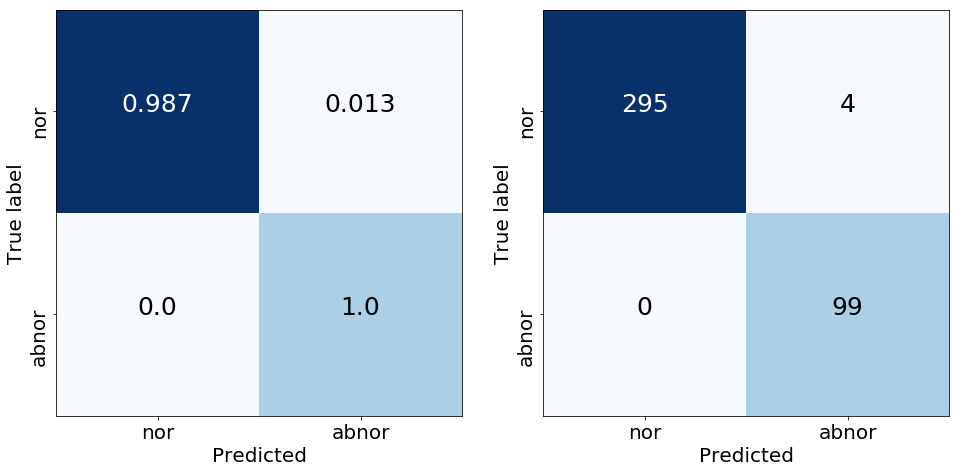

In [1129]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [1130]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

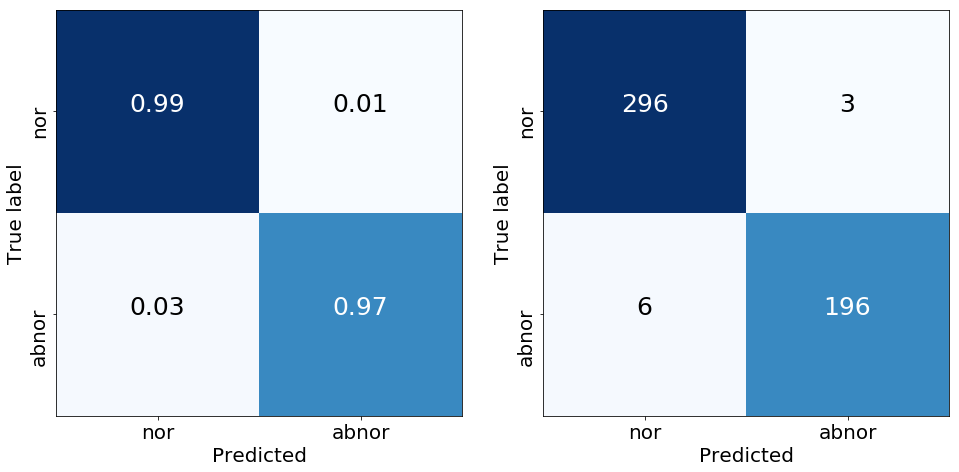

In [1131]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [1132]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

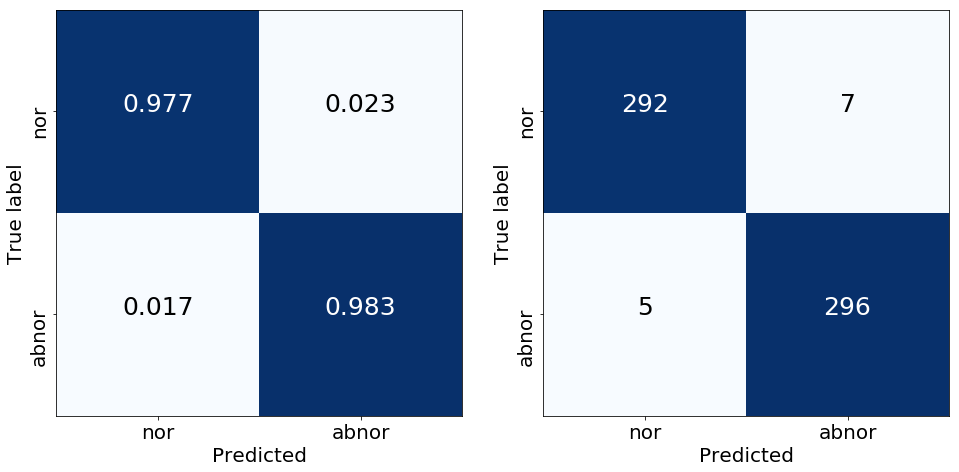

In [1133]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [1134]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

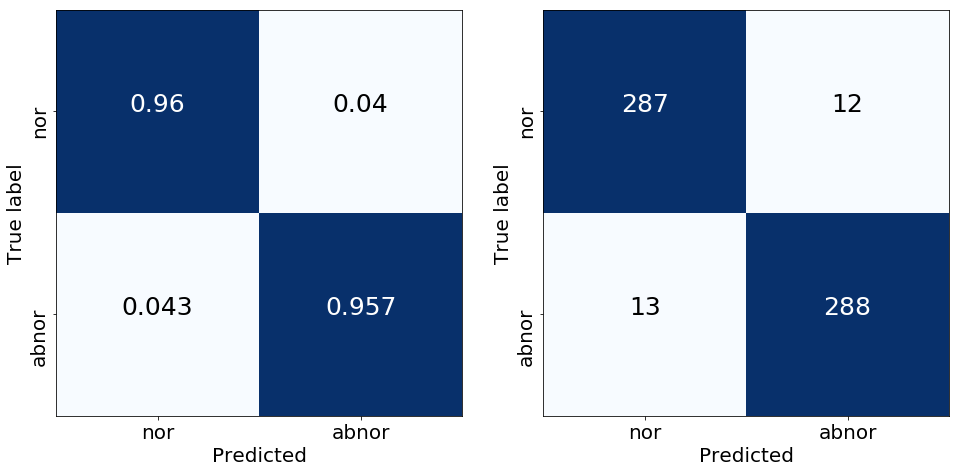

In [1135]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## False cases

In [22]:
testset = np.vstack([neg_img, redspot_img, angio_img, active_img, 
                      ero_img, ulcer_img, str_img])

filename = np.hstack([neg_name, redspot_name, angio_name, active_name, 
                      ero_name, ulcer_name, str_name])

In [23]:
def fp_fn_list(name, prob, label):

    pred = np.argmax(prob, axis = 1)
    true = np.argmax(label, axis = 1)

    fp_list, fn_list = [], []
    for n, p, t in zip(name, pred, true):
        if p == 1:
            if p != t:
                fp_list.append(n)
        elif p == 0:
            if p != t:
                fn_list.append(n)
    return np.asarray(fp_list), np.asarray(fn_list)

In [24]:
b_fp_list, b_fn_list = fp_fn_list(name = filename, prob = b_outputs, label = labels)
e_fp_list, e_fn_list = fp_fn_list(name = filename, prob = e_outputs, label = labels)

In [28]:
len(e_fn_list)

5

In [1139]:
b_fp_testset = testset[np.asarray([int(np.where(filename == i)[0]) for i in b_fp_list])]
b_fn_testset = testset[np.asarray([int(np.where(filename == i)[0]) for i in b_fn_list])]

e_fp_testset = testset[np.asarray([int(np.where(filename == i)[0]) for i in e_fp_list])]
e_fn_testset = testset[np.asarray([int(np.where(filename == i)[0]) for i in e_fn_list])]

In [1140]:
b_fn_list

array(['죽이___03-48-30___2044515.jpg', '희정___00-27-49___2005392.jpg',
       'GN___05-57-39___1042922.jpg', 'GN___05-57-47___1042938.jpg',
       '연정___02-43-36___1019635.jpg', '규심___04-57-00___2049116.jpg',
       '연정___04-31-00___1032525.jpg', '연정___04-47-56___1034556.jpg',
       '명박___04-16-24___1030773.jpg', '명박___04-23-55___1031674.jpg',
       '욱최___00-52-03___2013193.jpg', '명박___05-26-46___1039217.jpg',
       '승이___12-01-00___1086529.jpg'], dtype='<U27')

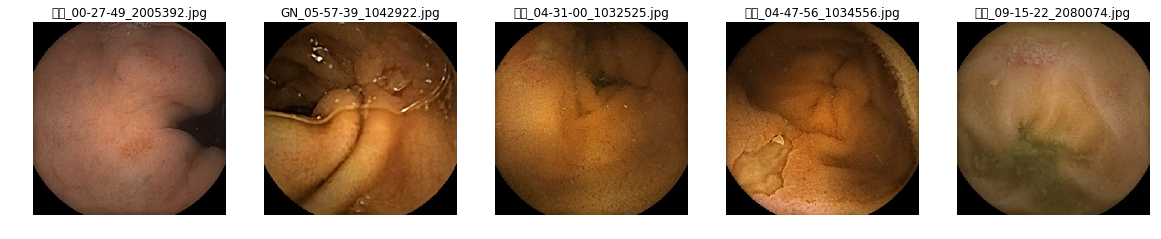

In [1141]:
plt.figure(figsize = (20, 36))
for i, name, img in zip(range(len(e_fn_testset)), e_fn_list, e_fn_testset):
    if i+1 > 40:
        break
    plt.subplot(8, 5, i+1)
    plt.title(name.split('___')[0] + '_'+ name.split('___')[1] + '_' + name.split('___')[2])
    plt.imshow(img)
    plt.axis('off')
plt.show()

## ROC curve

In [1142]:
from scipy.stats import sem, t
from scipy import mean
from sklearn.model_selection import KFold

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))


def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [1172]:
n_g = 50

_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, h_idxs = k_fold_idx(n_fold = n_g, dataset = h_label)
_, d_idxs = k_fold_idx(n_fold = n_g, dataset = d_label)

In [1173]:
def tri_shuffle(x, y, z):
    rand_idx = np.random.choice(len(x), len(x), replace = False)
    return x[rand_idx], y[rand_idx], z[rand_idx]

In [1174]:
h_label, h_b_output, h_e_output = tri_shuffle(h_label, h_b_output, h_e_output)
d_label, d_b_output, d_e_output = tri_shuffle(d_label, d_b_output, d_e_output)

In [1175]:
len(neg_b_output)

299

In [1176]:
len(h_b_output)

99

In [1177]:
len(d_b_output)

202

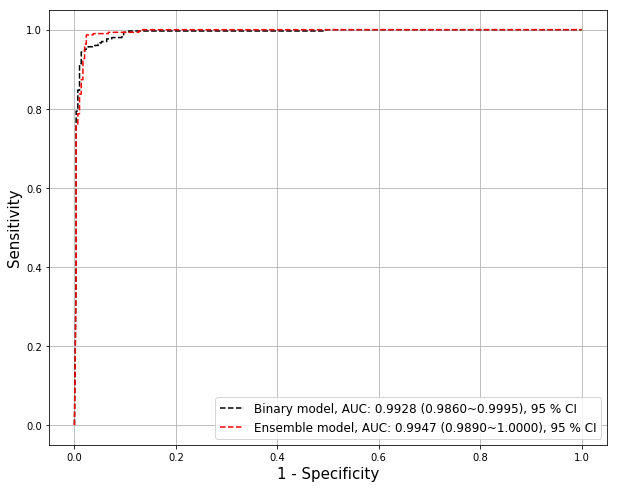

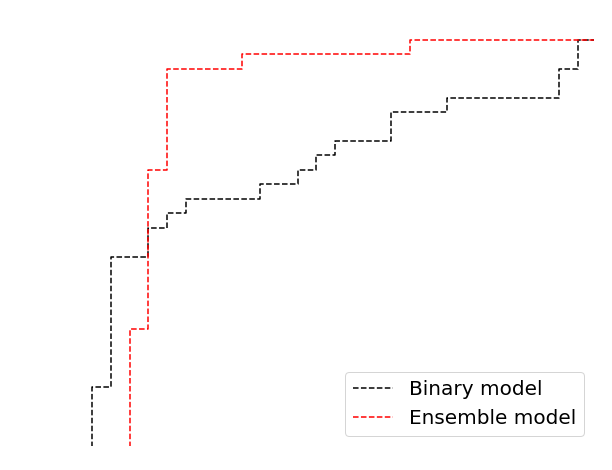

In [1178]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, h_idx, d_idx in zip(neg_idxs, h_idxs, d_idxs):

    labels = np.vstack([neg_label[n_idx], h_label[h_idx], d_label[d_idx]])
    b_outputs = np.vstack([neg_b_output[n_idx], h_b_output[h_idx], d_b_output[d_idx]]) 
    e_outputs = np.vstack([neg_e_output[n_idx], h_e_output[h_idx], d_e_output[d_idx]]) 
    
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

labels = np.vstack([neg_label, h_label, d_label])
b_outputs = np.vstack([neg_b_output, h_b_output, d_b_output])
e_outputs = np.vstack([neg_e_output, h_e_output, d_e_output])

labels, b_outputs, e_outputs = tri_shuffle(labels, b_outputs, e_outputs)

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(b_fpr, b_tpr, 'k--', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.plot(e_fpr, e_tpr, 'r--', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, round(e_auc_u)))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()
# fig.savefig('./results/roc_curve.png', bbox_inches='tight', dpi = 300)

fig = plt.figure(figsize=(10, 8))
plt.plot(b_fpr, b_tpr, 'k--', label="Binary model")
plt.plot(e_fpr, e_tpr, 'r--', label="Ensemble model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
plt.axis('off')
fig.show()
# fig.savefig('./results/roc_curve_enlarged.png', bbox_inches='tight', dpi = 300)

In [1179]:
auc(e_fpr, e_tpr)

0.9935332614806831

In [1180]:
auc(b_fpr, b_tpr)

0.9917387970977456

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [1181]:
e_CM, b_CM = [], []

for n_idx, h_idx, d_idx in zip(neg_idxs, h_idxs, d_idxs):
    labels = np.vstack([neg_label[n_idx], h_label[h_idx], d_label[d_idx]])
    b_outputs = np.vstack([neg_b_output[n_idx], h_b_output[h_idx], d_b_output[d_idx]]) 
    e_outputs = np.vstack([neg_e_output[n_idx], h_e_output[h_idx], d_e_output[d_idx]]) 
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

In [1182]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [1183]:
b_metrices

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.92307692, 1.        , 0.83333333, 1.        , 0.875     ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.91666667, 0.83333333, 1.        , 0.85714286, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.91666667, 1.        , 0.83333333, 1.        , 0.85714286],
       [0.91666667, 0.83333333, 1.        , 0.85714286, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.91666667, 1.        , 0.83333333, 1.        , 0.85714286],
       [0.91666667, 1.        , 0.83333333, 1.        , 0.85714286],
       [1.        , 1.        , 1.

In [1184]:
e_metrices

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.92307692, 1.        , 0.83333333, 1.        , 0.875     ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.91666667, 0.83333333, 1.        , 0.85714286, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.91666667, 0.83333333, 1.

In [1185]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 95.85 (94.24 ~ 97.45)
Sen --- 95.67 (93.17 ~ 98.16)
Spec --- 96.00 (93.74 ~ 98.26)
NPV --- 96.36 (94.28 ~ 98.43)
PPV --- 96.56 (94.65 ~ 98.48)

Ensemble model
Accr --- 98.01 (97.00 ~ 99.03)
Sen --- 98.33 (96.90 ~ 99.77)
Spec --- 97.67 (96.01 ~ 99.33)
NPV --- 98.57 (97.34 ~ 99.80)
PPV --- 98.04 (96.64 ~ 99.43)


### Equal-Variance Test

In [1186]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 9.758, pvalue=0.001785906987
bartlett test for sensitivity: 14.169, pvalue=0.000167068155
bartlett test for specificity: 4.497, pvalue=0.033963118410
bartlett test for negative predictive values: 12.709, pvalue=0.000363864512
bartlett test for positive predictive values: 4.692, pvalue=0.030305962186


In [1187]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 5.268, pvalue=0.023850566782
levene test for sensitivity: 3.461, pvalue=0.065816833259
levene test for specificity: 1.429, pvalue=0.234746578227
levene test for negative predictive values: 3.400, pvalue=0.068210945434
levene test for positive predictive values: 1.555, pvalue=0.215388307554


### Normality Test

In [1188]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.180, pvalue=0.395939863171
Kolmogorov-Smirnov test for sensitivity: 0.120, pvalue=0.869261887041
Kolmogorov-Smirnov test for specificity: 0.080, pvalue=0.997710976491
Kolmogorov-Smirnov test for negative predictive values: 0.120, pvalue=0.869261887041
Kolmogorov-Smirnov test for positive predictive values: 0.080, pvalue=0.997710976491


### Wilcoxon signed-ranks test (not normal and paired group)

In [1189]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 30.000, pvalue=0.009436397248
wilcoxon signed-ranks test for sensitivity: 4.500, pvalue=0.012934093265
wilcoxon signed-ranks test for specificity: 16.500, pvalue=0.108809430041
wilcoxon signed-ranks test for negative predictive values: 6.500, pvalue=0.023342202013
wilcoxon signed-ranks test for positive predictive values: 18.000, pvalue=0.155450191284


### Paired two-sample t-Test (normal and paired group)

In [1190]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: -3.066, pvalue=0.003526388643
t-statistics for sensitivity: -2.682, pvalue=0.009949152542
t-statistics for specificity: -1.528, pvalue=0.133060423984
t-statistics for negative predictive values: -2.653, pvalue=0.010716112666
t-statistics for positive predictive values: -1.538, pvalue=0.130546987700


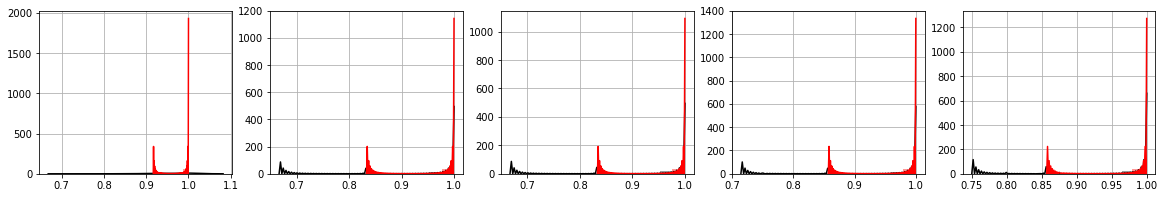

In [1191]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()